In [1]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm

from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, models, transforms

## Device

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cpu')

In [3]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14 = dinov2_vits14.to(device)

Using cache found in C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Mudasir Hussain/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [4]:
ls

 Volume in drive E is DATA
 Volume Serial Number is B867-DA30

 Directory of E:\[1]-Cascade learning-Unsafe behavior of cranes\ml_mo\safety_status_classification_module\classification

22/09/2024  10:19 am    <DIR>          .
20/09/2024  11:30 am    <DIR>          ..
20/09/2024  12:04 pm    <DIR>          .ipynb_checkpoints
20/09/2024  11:41 am    <DIR>          classification_data
20/09/2024  12:15 pm    <DIR>          classification_dataset
10/08/2024  05:10 pm            53,006 confusion_matrix.png
10/08/2024  05:11 pm            79,416 dino_classification_results.ipynb
22/09/2024  10:19 am            70,838 dino_classification_training.ipynb
19/07/2024  04:12 am        88,688,561 dino_model.pth
20/07/2024  12:33 pm        88,725,096 dino_model_.pth
20/07/2024  12:33 pm        88,725,279 dino_model_1.pth
02/08/2024  11:15 am            77,176 tower_crane_vit.ipynb
02/08/2024  11:17 am            65,788 VIT_Mobile_crane.ipynb
01/08/2024  07:51 am       343,307,362 vit_mobile_crane_ac

In [4]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

# Set a seed for reproducibility
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def collect_images(base_path, label):
    images = []
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        i=0
        for img_file in os.listdir(folder_path):
            if img_file.endswith(('.jpg', '.jpeg', '.png')):  # Add more extensions if needed
                images.append((os.path.join(folder_path, img_file), label))
                
    return images

# Collect images from both directories
safe_images = collect_images('classification_dataset/Mobile_crane/Safe operations', label=0)
unsafe_images = collect_images('classification_dataset/Mobile_crane/Unsafe operations', label=1)
near_miss_incident_images = collect_images('classification_dataset/Mobile_crane/Near miss incidents', label=2)
incidents_images = collect_images('classification_dataset/Mobile_crane/Incidents', label=3)

safe_images += collect_images('classification_dataset/Tower_crane/Safe operations', label=0)
unsafe_images += collect_images('classification_dataset/Tower_crane/Unsafe operations', label=1)
near_miss_incident_images += collect_images('classification_dataset/Tower_crane/Near miss incidents', label=2)
incidents_images += collect_images('classification_dataset/Tower_crane/Incidents', label=3)


# Combine images and split into train/test
all_images = safe_images + unsafe_images + near_miss_incident_images + incidents_images
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=seed_value)

# Print out the number of images in each set
print(f"Training images: {len(train_images)}")
print(f"Testing images: {len(test_images)}")


Training images: 18444
Testing images: 4611


## Prepare Dataset

In [5]:
class CustomImageDataset(datasets.VisionDataset):
    def __init__(self, image_label_pairs, transform=None):
        super().__init__(root="", transform=transform)
        self.image_paths = [img[0] for img in image_label_pairs]
        self.labels = [img[1] for img in image_label_pairs]
        self.transform = transform
        self.classes = ['Safe Operations', 'Unsafe Operations', "Near-Miss Incidents", "Incidents"]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = datasets.folder.default_loader(img_path)
        
        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Create datasets
image_datasets = {
    'train': CustomImageDataset(train_images, transform=data_transforms['train']),
    'test': CustomImageDataset(test_images, transform=data_transforms['test'])
}

# Output the dataset sizes
print(f"Training set size: {len(image_datasets['train'])}")
print(f"Test set size: {len(image_datasets['test'])}")

Training set size: 18444
Test set size: 4611


In [6]:
image_datasets

{'train': Dataset CustomImageDataset
     Number of datapoints: 18444
     Root location: 
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset CustomImageDataset
     Number of datapoints: 4611
     Root location: 
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [7]:
batch_size = 16
num_workers = 4
data_loaders = {x: DataLoader(image_datasets[x], shuffle=True, batch_size=batch_size, num_workers=0)
                for x in ['train', 'test']}


In [8]:
for img, label in data_loaders['train']:
    print(img.shape)
    print(label)
    break

torch.Size([16, 3, 224, 224])
tensor([3, 3, 3, 0, 0, 1, 0, 1, 0, 2, 3, 0, 1, 1, 3, 2])


In [9]:
class_names = image_datasets['train'].classes
print(class_names)
len(class_names)

['Safe Operations', 'Unsafe Operations', 'Near-Miss Incidents', 'Incidents']


4

## Model multi-class classification

In [10]:
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self, n_classes=1):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vits14
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        # x = torch.softmax(x)
        return x

model = DinoVisionTransformerClassifier(n_classes=len(class_names))
model = model.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
input_data = torch.randn(16, 3, 224, 224)
out=model(input_data)
print(out.shape)

torch.Size([16, 4])


In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 22156164


## Train

In [13]:
from sklearn.metrics import f1_score
import torch
import numpy as np
from tqdm import tqdm

num_epoch = 20

def calculate_score(labels, predictions):
    # Calculate F1 score and accuracy
    f1 = f1_score(labels, predictions, average='weighted')  # Weighted average for multi-class
    accuracy = np.mean(labels == predictions)
    return f1, accuracy

# Assuming criterion = nn.CrossEntropyLoss()
model.train()
for epoch in range(num_epoch):
    train_acc = 0
    train_loss = 0
    all_labels = []  
    all_predictions = []

    loop = tqdm(data_loaders['train'])
    for idx, (features, labels) in enumerate(loop):
        features = features.to(device)
        labels = labels.to(device).long()  # Multi-class expects long type

        optimizer.zero_grad()
        outputs = model(features)  # Model should return raw logits

        # Compute loss for multi-class classification
        loss = criterion(outputs, labels)
        
        # Predictions using argmax for multi-class
        predictions = torch.argmax(outputs, dim=1)

        # Accuracy calculation
        correct = (predictions == labels).sum().item()
        accuracy = correct / labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

        loss.backward()
        optimizer.step()

        # Update loop description with loss and accuracy
        loop.set_description(f"Epoch [{epoch}/{num_epoch}]")
        loop.set_postfix(loss=loss.item(), acc=accuracy)

    # Calculate F1 score and accuracy for the epoch
    f1, accuracy = calculate_score(np.array(all_labels), np.array(all_predictions))
    print(f"Epoch {epoch + 1}, F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")


Epoch [0/20]: 100%|█████████████████████████████████████████| 1153/1153 [54:59<00:00,  2.86s/it, acc=0.917, loss=0.461]


Epoch 1, F1 Score: 0.7256, Accuracy: 0.7272


Epoch [1/20]: 100%|█████████████████████████████████████████| 1153/1153 [52:38<00:00,  2.74s/it, acc=0.917, loss=0.115]


Epoch 2, F1 Score: 0.9201, Accuracy: 0.9202


Epoch [2/20]: 100%|████████████████████████████████████████████| 1153/1153 [52:56<00:00,  2.75s/it, acc=1, loss=0.0597]


Epoch 3, F1 Score: 0.9558, Accuracy: 0.9558


Epoch [3/20]: 100%|█████████████████████████████████████████████| 1153/1153 [52:56<00:00,  2.75s/it, acc=1, loss=0.012]


Epoch 4, F1 Score: 0.9653, Accuracy: 0.9653


Epoch [4/20]: 100%|█████████████████████████████████████████| 1153/1153 [53:29<00:00,  2.78s/it, acc=0.833, loss=0.439]


Epoch 5, F1 Score: 0.9719, Accuracy: 0.9719


Epoch [5/20]: 100%|██████████████████████████████████████████| 1153/1153 [54:49<00:00,  2.85s/it, acc=0.917, loss=0.11]


Epoch 6, F1 Score: 0.9767, Accuracy: 0.9767


Epoch [6/20]: 100%|████████████████████████████████████████████| 1153/1153 [54:45<00:00,  2.85s/it, acc=1, loss=0.0414]


Epoch 7, F1 Score: 0.9773, Accuracy: 0.9773


Epoch [7/20]: 100%|████████████████████████████████████████████| 1153/1153 [55:32<00:00,  2.89s/it, acc=1, loss=0.0268]


Epoch 8, F1 Score: 0.9834, Accuracy: 0.9834


Epoch [8/20]: 100%|███████████████████████████████████████████| 1153/1153 [56:17<00:00,  2.93s/it, acc=1, loss=0.00224]


Epoch 9, F1 Score: 0.9847, Accuracy: 0.9847


Epoch [9/20]: 100%|███████████████████████████████████████████| 1153/1153 [57:09<00:00,  2.97s/it, acc=1, loss=0.00649]


Epoch 10, F1 Score: 0.9863, Accuracy: 0.9863


Epoch [10/20]: 100%|██████████████████████████████████████████| 1153/1153 [56:31<00:00,  2.94s/it, acc=1, loss=0.00587]


Epoch 11, F1 Score: 0.9876, Accuracy: 0.9876


Epoch [11/20]: 100%|██████████████████████████████████████████| 1153/1153 [56:39<00:00,  2.95s/it, acc=1, loss=0.00761]


Epoch 12, F1 Score: 0.9886, Accuracy: 0.9886


Epoch [12/20]: 100%|█████████████████████████████████████████| 1153/1153 [57:17<00:00,  2.98s/it, acc=1, loss=0.000106]


Epoch 13, F1 Score: 0.9906, Accuracy: 0.9906


Epoch [13/20]: 100%|██████████████████████████████████████████| 1153/1153 [58:42<00:00,  3.06s/it, acc=1, loss=0.00683]


Epoch 14, F1 Score: 0.9862, Accuracy: 0.9862


Epoch [14/20]: 100%|██████████████████████████████████████████| 1153/1153 [58:32<00:00,  3.05s/it, acc=1, loss=0.00231]


Epoch 15, F1 Score: 0.9911, Accuracy: 0.9911


Epoch [15/20]: 100%|██████████████████████████████████████████| 1153/1153 [58:14<00:00,  3.03s/it, acc=1, loss=0.00326]


Epoch 16, F1 Score: 0.9914, Accuracy: 0.9914


Epoch [16/20]: 100%|██████████████████████████████████████████| 1153/1153 [57:48<00:00,  3.01s/it, acc=1, loss=0.00059]


Epoch 17, F1 Score: 0.9931, Accuracy: 0.9931


Epoch [17/20]: 100%|███████████████████████████████████████████| 1153/1153 [58:27<00:00,  3.04s/it, acc=1, loss=0.0315]


Epoch 18, F1 Score: 0.9920, Accuracy: 0.9920


Epoch [18/20]: 100%|███████████████████████████████████████████| 1153/1153 [58:38<00:00,  3.05s/it, acc=1, loss=0.0169]


Epoch 19, F1 Score: 0.9925, Accuracy: 0.9925


Epoch [19/20]: 100%|███████████████████████████████████████| 1153/1153 [1:02:00<00:00,  3.23s/it, acc=1, loss=0.000172]

Epoch 20, F1 Score: 0.9935, Accuracy: 0.9935


In [16]:
# Generate classification report and confusion matrix
report = classification_report(all_labels, all_predictions, target_names=class_names)
print(f"Classification Report for Epoch {epoch + 1}:\n", report)

Classification Report for Epoch 20:
                      precision    recall  f1-score   support

    Safe Operations       0.99      0.99      0.99      4046
  Unsafe Operations       0.99      0.99      0.99      4972
Near-Miss Incidents       1.00      1.00      1.00      2544
          Incidents       0.99      0.99      0.99      6882

           accuracy                           0.99     18444
          macro avg       0.99      0.99      0.99     18444
       weighted avg       0.99      0.99      0.99     18444



In [14]:
model_save_path = "dino_model_epoch20.pth"
torch.save(model, model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to dino_model_epoch20.pth


## Testing model on test dataset

In [30]:
correct = 0
total = 0
test_prediction = []
test_labels = []

model.eval()

with torch.no_grad():
    print("started the calculation of testing accuracy")
    for features, test_label in data_loaders["test"]:
        test_features = features.to(device)
        test_label = test_label.to(device).long() 
        test_outputs = model(test_features)

        # Convert outputs to multi-class predictions using argmax
        test_predicted = torch.argmax(test_outputs, dim=1)

        # Iterate through the batch to convert predicted indices to class names
        for i in range(test_predicted.size(0)):  # Iterate through each prediction
            class_label = class_names[test_predicted[i].item()]
            # print(f"Predicted class label: {class_label}")

        # Update total for accuracy calculation
        total += test_label.size(0)

        # Append the labels and predictions for F1 score and accuracy calculation
        test_labels += test_label.cpu().numpy().tolist()
        test_prediction += test_predicted.cpu().numpy().tolist()

# Calculate F1 score and accuracy for the test dataset
f1, accuracy = calculate_score(np.array(test_labels), np.array(test_prediction))
print(f'F1 Score: {f1:.4f}')
print(f'Accuracy: {accuracy * 100:.2f} %')

started the calculation of testing accuracy
F1 Score: 0.9924
Accuracy: 99.24 %


## Calssification Report

In [34]:
print(classification_report(test_labels, test_prediction, target_names=class_names))

                     precision    recall  f1-score   support

    Safe Operations       1.00      0.99      0.99      1016
  Unsafe Operations       0.99      0.99      0.99      1201
Near-Miss Incidents       1.00      1.00      1.00       638
          Incidents       0.99      0.99      0.99      1756

           accuracy                           0.99      4611
          macro avg       0.99      0.99      0.99      4611
       weighted avg       0.99      0.99      0.99      4611



In [31]:
test_cm = confusion_matrix(test_labels, test_prediction)
df_test_cm = pd.DataFrame(
    test_cm,
    index = class_names,
    columns = class_names
)
df_test_cm

,Safe Operations,Unsafe Operations,Near-Miss Incidents,Incidents
Safe Operations,1003,5,0,8
Unsafe Operations,2,1194,3,2
Near-Miss Incidents,0,0,636,2
Incidents,0,13,0,1743


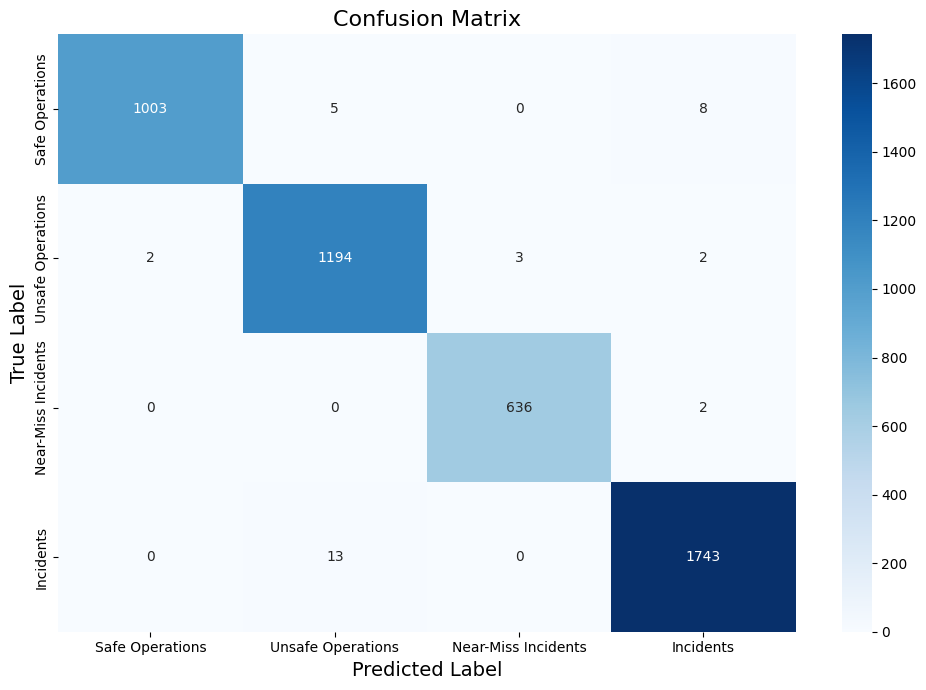

In [40]:
def show_confusion_matrix(confusion_matrix, class_names, title="Confusion Matrix", save_path="confusion_matrix.png"):
    # Create a figure with a larger size for clarity
    plt.figure(figsize=(10, 7))

    # Plot the heatmap
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", 
                       xticklabels=class_names, yticklabels=class_names)

    # Add title and axis labels
    plt.title(title, fontsize=16)
    plt.ylabel("True Label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

    # Adjust layout to prevent clipping
    plt.tight_layout()
    # Save the confusion matrix to a file
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)  # Save as PNG with tight layout

    # Show the plot
    plt.show()

show_confusion_matrix(df_test_cm, class_names, save_path="confusion_matrix_multi-class.png")